In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TextVectorization
from wordcloud import WordCloud, STOPWORDS

2024-10-21 20:14:28.767553: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 20:14:28.771778: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 20:14:28.783922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 20:14:28.802538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 20:14:28.807555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 20:14:28.822295: I tensorflow/core/platform/cpu_feature_gu

In [2]:
df = pd.read_csv("rnn_data.csv")

# Prepare target column (1: spam, 0: ham)
df['target'] = np.where(df['Category'] == 'spam', 1, 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['target'], test_size=0.2, random_state=42)


In [3]:
# TextVectorization layer
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=30)
vectorizer.adapt(X_train)

X_train_vec = vectorizer(X_train)
X_test_vec = vectorizer(X_test)

I0000 00:00:1729521871.098196   11559 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-21 20:14:31.098568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# RNN model
model = Sequential([
    Embedding(input_dim=20001, output_dim=32),  # One extra for padding (20000 + 1)
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train_vec, y_train, epochs=10, batch_size=60, validation_split=0.2)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9132 - loss: 0.2814 - val_acc: 0.9406 - val_loss: 0.1827
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9734 - loss: 0.1011 - val_acc: 0.9518 - val_loss: 0.1388
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9829 - loss: 0.0726 - val_acc: 0.9574 - val_loss: 0.1530
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9898 - loss: 0.0472 - val_acc: 0.9664 - val_loss: 0.1208
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9890 - loss: 0.0446 - val_acc: 0.9731 - val_loss: 0.0981
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9960 - loss: 0.0248 - val_acc: 0.9731 - val_loss: 0.0986
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9928 - loss: 0.0372 - val_acc: 0.9697 - val_loss: 0.1115
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9969 - loss: 0.0183 - val_acc: 0.9686 - val_loss: 0.1355
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9980

In [5]:
# Prediction
y_pred_proba = model.predict(X_test_vec)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Confusion Matrix:
 [[952  14]
 [ 18 131]]
Accuracy: 0.9713
Precision: 0.9034
Recall: 0.8792
F1 Score: 0.8912
ROC_AUC: 0.9833


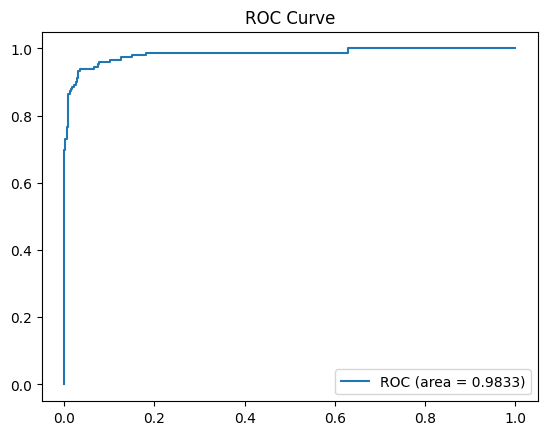

In [6]:
# Evaluation function
def evaluate_model(y_true, y_pred_proba):
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC_AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC (area = {auc(fpr, tpr):.4f})')
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

evaluate_model(y_test, y_pred_proba)

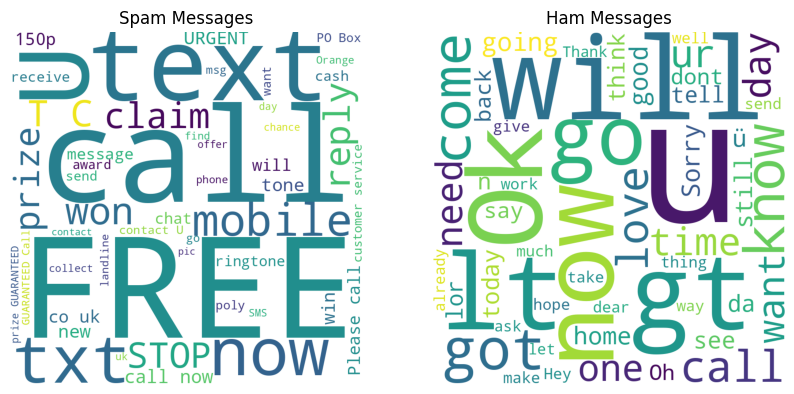

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.8442627]]


In [7]:
# Generate WordCloud for spam and ham
spam_words = ' '.join(df[df['target'] == 1]['Message'])
ham_words = ' '.join(df[df['target'] == 0]['Message'])

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS, max_words=50).generate(text)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
generate_wordcloud(spam_words, "Spam Messages")

plt.subplot(1, 2, 2)
generate_wordcloud(ham_words, "Ham Messages")
plt.show()

# Test on new message
msg = "free sms service for anyone"
input_seq = vectorizer([msg])
print(model.predict(input_seq))